In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

## How to sample a multi-dimensional Gaussian

In [2]:
def log_prob(x, mu, cov):      
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))

It is important that the first argument of the probability function is the position of a single “walker” (a N dimensional numpy array). The following arguments are going to be constant every time the function is called and the values come from the *args* parameter of our *EnsembleSampler* that we’ll see soon.

Now, we’ll set up the specific values of those “hyperparameters” in 5 dimensions:

In [3]:
ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)

#cov is Sigma - square N-by-N covariance matrix
cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

How about we use 32 walkers? Before we go on, we need to guess a starting point for each of the 32 walkers. 

This position will be a 5-dimensional vector so the initial guess should be a 32-by-5 array. It’s not a very good guess but we’ll just guess a random number between 0 and 1 for each component:

In [4]:
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

#The main interface provided by emcee is the EnsembleSampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

#Function log_prob required two extra arguments when it is called. 
#By setting up our sampler with the args argument, the probability function should be called as:
log_prob(p0[0], means, cov)

-2.5960945890854434

If we didn’t provide any args parameter, the calling sequence would be ***log_prob(p0[0])*** instead.

It’s generally a good idea to run a few **“burn-in”** steps in your MCMC chain to let the walkers explore the parameter space a bit and get settled into the maximum of the density. We’ll run a burn-in of, for example, 100 steps starting from our initial guess p0:

In [5]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

You’ll notice that I saved the final position of the walkers (after the 100 steps) to a variable called **state**. You can check out what will be contained in the other output variables by looking at the documentation for the *EnsembleSampler.run_mcmc()* function. The call to the *EnsembleSampler.reset()* method clears all of the important bookkeeping parameters in the sampler so that we get a fresh start. It also clears the current positions of the walkers so it’s a good thing that we saved them first.

Now, we can do our production run of 10000 steps:

In [6]:
sampler.run_mcmc(state, 10000);

The *.get_chain()* method will return an array with the shape (10000, 32, 5) giving the parameter values for each walker at each step in the chain. Take note of that shape and make sure that you know where each of those numbers come from. You can make **histograms** of these samples to get an estimate of the density that you were sampling:

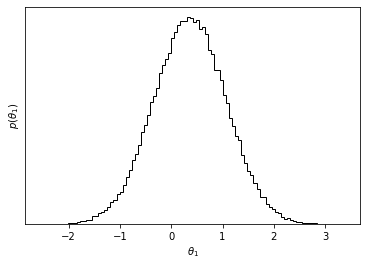

In [7]:
#The samples can be accessed using the EnsembleSampler.get_chain() method
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

Another good test of whether or not the sampling went well is to check the **mean acceptance fraction** of the ensemble using the EnsembleSampler.acceptance_fraction() property & and the **integrated autocorrelation time**




In [8]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean acceptance fraction: 0.552
Mean autocorrelation time: 57.112 steps


## Fitting a model using MCMC to data

When you approach a new problem, the first step is generally to write down the ***likelihood function*** (the probability of a dataset given the model parameters). This is equivalent to describing the generative procedure for the data. In this case, we’re going to consider a linear model where the quoted uncertainties are underestimated by a constant fractional amount. You can generate a synthetic dataset from this model:

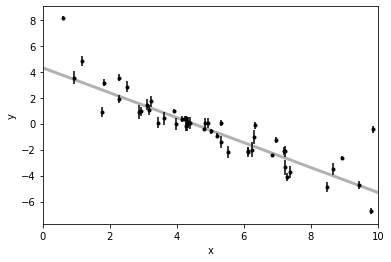

In [9]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

The true model is shown as the thick grey line and the effect of the underestimated uncertainties is obvious when you look at this figure. The standard way to fit a line to these data (assuming independent Gaussian error bars) is **linear least squares**. Linear least squares is appealing because solving for the parameters—and their associated uncertainties—is simply a linear algebraic operation. Following the notation in Hogg, Bovy & Lang (2010), the linear least squares solution to these data is

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


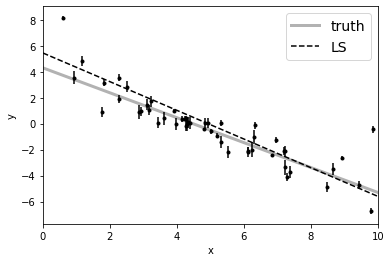

In [10]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")    #solving y=mx+b basically
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

This figure shows the least-squares estimate of the line parameters as a dashed line. This isn’t an unreasonable result but the uncertainties on the slope and intercept seem a little small (because of the small error bars on most of the data points).

### Maximum Likelihood Estimation

The least squares solution found in the previous section is the **maximum likelihood** result for a model where the error bars are assumed correct, Gaussian and independent. We know, of course, that this isn’t the right model. Unfortunately, there isn’t a generalization of least squares that supports a model like the one that we know to be true. Instead, we need to write down **the likelihood function** and numerically optimize it. 

This likelihood function is simply a Gaussian where the variance is underestimated by some fractional amount: $f$. In Python, you would code this up as:

In [11]:
def log_likelihood(theta, x, y, yerr):   #log of f to keep f always positive
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

A good way of finding this numerical optimum of this likelihood function is to use the **scipy.optimize** module:

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


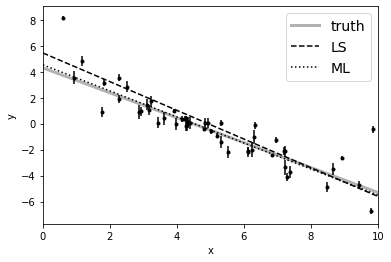

In [12]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))    #minimize used here
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

It’s worth noting that the optimize module *minimizes* functions whereas we would like to maximize the likelihood. This goal is equivalent to minimizing the *negative* likelihood (or in this case, the negative log likelihood). In this figure, the maximum likelihood (ML) result is plotted as a dotted black line—compared to the true model (grey line) and linear least-squares (LS; dashed line). That looks better!

The problem now: how do we estimate the uncertainties on *m and b*? What’s more, we probably don’t really care too much about the value of *f* but it seems worthwhile to propagate any uncertainties about its value to our final estimates of m and b. **This is where MCMC comes in.**

### Marginalisation and uncertainty estimation

A common reason to use MCMC is that you would like to marginalize over some **“nuisance parameters”** and find an estimate of the **posterior probability function** (the distribution of parameters that is consistent with your dataset) for others. MCMC lets you do both of these things in one fell swoop! You need to start by writing down the posterior probability function (up to a constant). We know already the likelihood function, we're only missing the **prior function**

This function encodes any previous knowledge that we have about the parameters: results from other experiments, physically acceptable ranges, etc. It is necessary that you write down priors if you’re going to use MCMC because all that MCMC does is draw samples from a probability distribution and you want that to be a probability distribution for your parameters.

This is important: **you cannot draw parameter samples from your likelihood function**. This is because a likelihood function is a probability distribution **over datasets** so, conditioned on model parameters, you can draw representative datasets (as demonstrated at the beginning of this exercise) but you cannot draw parameter samples.

In this example, we’ll use uniform (so-called “uninformative”) priors on *m, b* and the logarithm of *f*. For example, we’ll use the following conservative prior on *m*: (check in website)

In code, the log-prior is (up to a constant):

In [13]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

Then, combining this with the definition of log_likelihood from above, the **full log-probability function** is:

In [14]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

After all this setup, it’s easy to sample this distribution using emcee. We’ll start by initializing the walkers in a tiny Gaussian ball around the maximum likelihood result (I’ve found that this tends to be a pretty good initialization in most cases) and then run 5,000 steps of MCMC.

In [15]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 470.60it/s]


Let’s take a look at what the sampler has done. A good first step is to look at the time series of the parameters in the chain. The samples can be accessed using the *EnsembleSampler.get_chain()* method. This will return an array with the shape (5000, 32, 3) giving the parameter values for each walker at each step in the chain. The figure below shows the positions of each walker as a function of the number of steps in the chain:

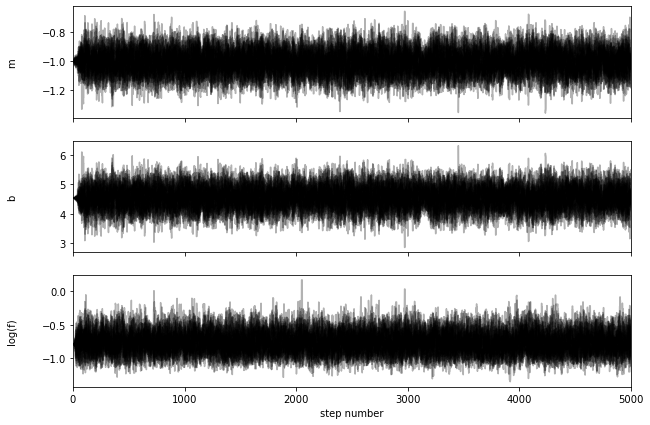

In [16]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

As mentioned above, the walkers start in small distributions around the maximum likelihood values and then they quickly wander and start exploring the full posterior distribution. In fact, after fewer than 50 steps, the samples seem pretty well “burnt-in”. That is a hard statement to make quantitatively, but we can look at an estimate of the *integrated autocorrelation time* (see the Autocorrelation analysis & convergence tutorial for more details):

In [17]:
tau = sampler.get_autocorr_time()
print(tau)

[39.99526726 39.76501919 41.02623912]


This suggests that only about 40 steps are needed for the chain to “forget” where it started. It’s *not unreasonable* to throw away a few times this number of steps as “burn-in”. Let’s discard the initial 100 steps, thin by about half the autocorrelation time (15 steps), and flatten the chain so that we have a flat list of samples:

In [18]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


## Results

Now that we have this list of samples, let’s make one of the most useful plots you can make with your MCMC results: **a corner plot**. You’ll need the *corner.py* module but once you have it, generating a corner plot is as simple as:

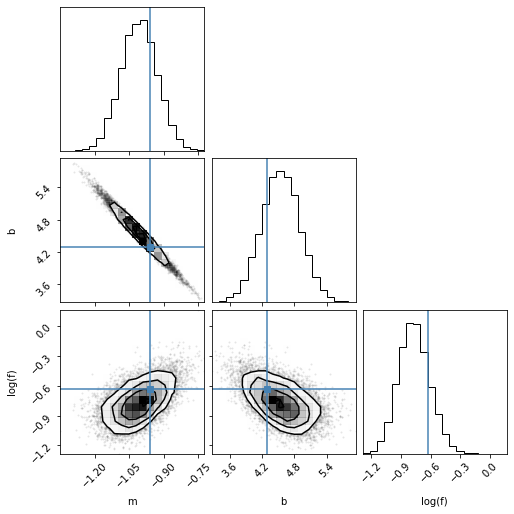

In [19]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

The corner plot shows all the one and two dimensional projections of the posterior probability distributions of your parameters. This is useful because it quickly demonstrates all of the covariances between parameters. Also, the way that you find the marginalized distribution for a parameter or set of parameters using the results of the MCMC chain is to project the samples into that plane and then make an N-dimensional histogram. That means that the corner plot shows the marginalized distribution for each parameter independently in the histograms along the diagonal and then the marginalized two dimensional distributions in the other panels.

Another diagnostic plot is **the projection of your results into the space of the observed data**. To do this, you can choose a few (say 100 in this case) samples from the chain and plot them on top of the data points:

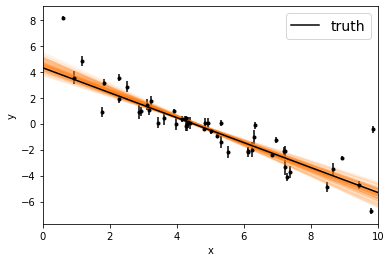

In [20]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

This leaves us with one question: which numbers should go in the abstract? There are a few different options for this but my favorite is to quote the uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the marginalized distributions. To compute these numbers for this example, you would run:

In [21]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Another emcee example

emcee is a python module that implements a very cool MCMC sampling algorithm cample an ensemble sampler. In order to more efficiently sample the parameter space, many samplers (called walkers) run in parallel and periodically exchange states. emcee is available from this website:

http://dan.iel.fm/emcee/current/

You can also install via pip or easy_install.

Similar to other examples, we start by making some fake data. In this case, we're going to do have a linear regression model with two predictor variables (x,y) and one outcome variable (z). The relation between them is: $[Z_n = \alpha + \beta_x x_n + \beta_y y_n + \epsilon]$ where \($\epsilon$\) is a Gaussian noise term.

In [22]:
from numpy import *
Nobs = 20
x_true = random.uniform(0,10, size=Nobs)
y_true = random.uniform(-1,1, size=Nobs)
alpha_true = 0.5
beta_x_true = 1.0
beta_y_true = 10.0
eps_true = 0.5
z_true = alpha_true + beta_x_true*x_true + beta_y_true*y_true
z_obs = z_true + random.normal(0, eps_true, size=Nobs)

We can plot the data through two diferent slices of the data. We'll color code each point by it's value of the other predictor to see the trend in both cases.

Text(0, 0.5, 'Z')

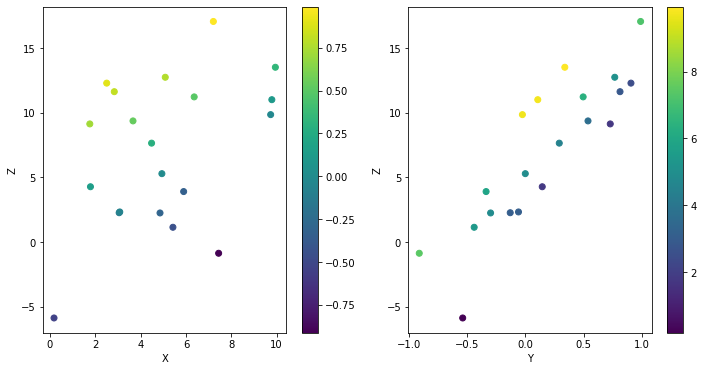

In [34]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x_true, z_obs, c=y_true, marker='o')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Z')
plt.subplot(1,2,2)
plt.scatter(y_true, z_obs, c=x_true, marker='o')
plt.colorbar()
plt.xlabel('Y')
plt.ylabel('Z')

The big difference between emcee and PyStan and pymc is that the module is all about the sampler and doesn't give you any build-in distributions. You have to write the entire probability function yourself. Following the example on emcee's site, we do this by writing log-prior, log-likelihood, and log-probability functions:

In [24]:
def lnprior(p):
    # The parameters are stored as a vector of values, so unpack them
    alpha,betax,betay,eps = p
    # We're using only uniform priors, and only eps has a lower bound
    if eps <= 0:
        return -inf
    return 0

def lnlike(p, x, y, z):
    alpha,betax,betay,eps = p
    model = alpha + betax*x + betay*y
    # the likelihood is sum of the lot of normal distributions
    denom = power(eps,2)
    lp = -0.5*sum(power((z - model),2)/denom + log(denom) + log(2*pi))
    return lp

def lnprob(p, x, y, z):
    lp = lnprior(p)
    if not isfinite(lp):
        return -inf
    return lp + lnlike(p, x, y, z)

At this point, the total probability $p\left(\theta|D\right)$ is given by lnprob. You can imagine that as the model gets more and more complicated and hiarchical, the coding will be much more complicated than with PyStan or pymc. Now, the pymc documentation recommends finding the maximum likelihood using scipy's optimize module:

In [26]:
import scipy.optimize as opt
nll = lambda *args: -lnlike(*args)
result = opt.minimize(nll, [alpha_true, beta_x_true, beta_y_true, eps_true],
                      args=(x_true, y_true, z_obs))
print (result['x'])

[0.29990793 1.00860826 9.90251564 0.44257724]


Now that we have the maximum likelihood, we must create a number of walkers to sample our parameters space and instantiate each with a slightly different starting point.

In [27]:
Nwalker,Ndim = 50,4
p0 = [result['x']+1.e-4*random.randn(Ndim) for i in range(Nwalker)]

We feed the lnprob and the initial staring points of the Nwalker walkers to the ensemble sampler and let it run. Multiprocessing is built in, so one can take advantage of multiple CPU's to run the walkers in parallel.

In [38]:
import emcee
sampler = emcee.EnsembleSampler(Nwalker,Ndim,lnprob,
                                args=(x_true,y_true,z_obs))
pos,prob,state = sampler.run_mcmc(p0, 500)

The sampler will now have a chains attribute which is an array with shape (Nwalker,N,Ndim) where N is the number of interations (500 in our inital run). We can plot these traces out to see what's happening. We'll just look at alpha.

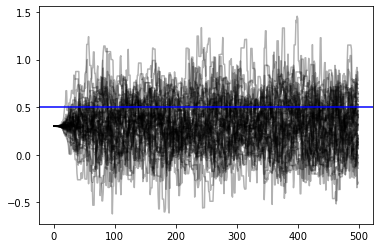

In [39]:
res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
plt.axhline(alpha_true, color='blue')

As you can see, the walkers start out all bundled together, but then start to explore the parameter space and finally converge on a fixed dispersion around a value close to the true value (in blue). We can run the sampler for longer. To do this, we reset the sampler (to get rid of the previous chain) and start where the sampler left off (pos).

In [40]:
sampler.reset()
pos,prob,state = sampler.run_mcmc(pos, 1000)

As well as chain, the sampler has a ***flatchain*** attribute which simply concatenates all the walkers' chains into one. So the array shape will be (N, Ndim). We compute the medians and plot the results of the model.

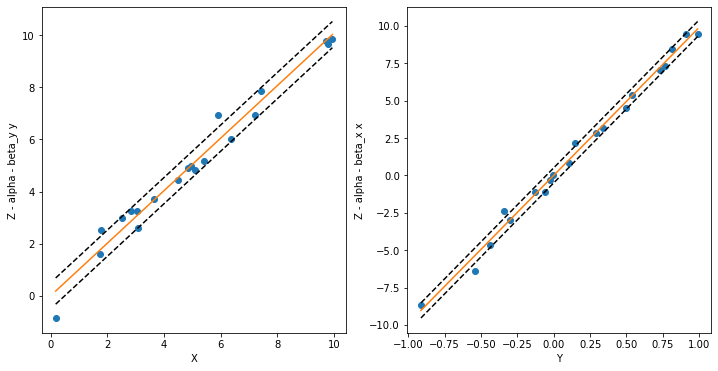

In [41]:
m_alpha,m_betax,m_betay,m_eps = median(sampler.flatchain, axis=0)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x_true, z_obs-m_alpha-m_betay*y_true, 'o')
plt.xlabel('X')
plt.ylabel('Z - alpha - beta_y y')
# Now plot the model
xx = array([x_true.min(), x_true.max()])
plt.plot(xx, xx*m_betax)
plt.plot(xx, xx*m_betax + m_eps, '--', color='k')
plt.plot(xx, xx*m_betax - m_eps, '--', color='k')
plt.subplot(1,2,2)
plt.plot(y_true, z_obs-m_alpha-m_betax*x_true, 'o')
plt.xlabel('Y')
plt.ylabel('Z - alpha - beta_x x')
yy = array([y_true.min(), y_true.max()])
plt.plot(yy, yy*m_betay)
plt.plot(yy, yy*m_betay + m_eps, '--', color='k')
plt.plot(yy, yy*m_betay - m_eps, '--', color='k')

If you have the triangle_plot plotting package, it's an easy way to look at the covariance of the various parameters. For this to work, we need the Markov chains in a 2D array indexed by [i,p], but that's already how the flatchain array is indexed, so we only have to feed it in.

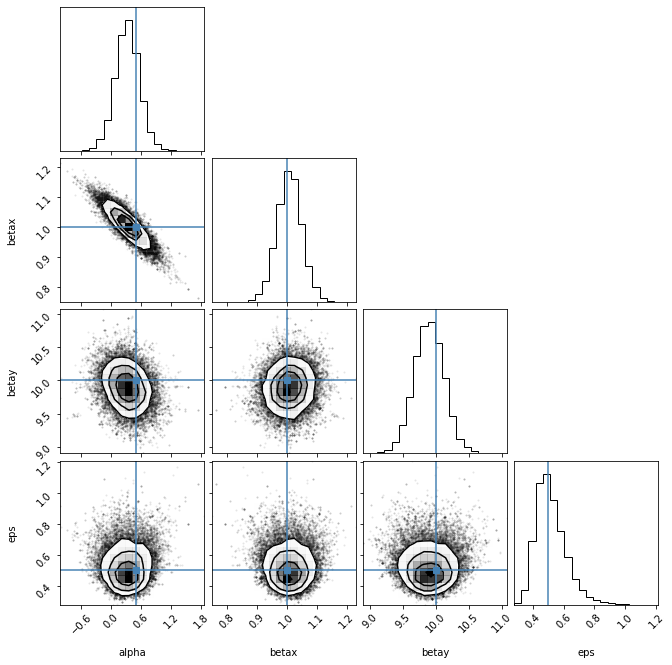

In [46]:
import triangle 
#for some reason triangle.corner is not available... so we use corner.corner() instead
tmp = corner.corner(sampler.flatchain, labels=['alpha','betax','betay','eps'], 
                truths=[alpha_true, beta_x_true, beta_y_true, eps_true])

# Yet another emcee example (Imad Pasha)

### Fitting the Earth's Milankovich Cycles - long but potentially more useful example

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

Located in this directory is a file containing the temperature change, age, deuterium content, etc., of the Earth's atmosphere over the last several million years, calculated from measurements of ice-core samples. For the purposes of this tutorial, we will be interested in only the age and temperature columns. The file is called 'ice_core_data.txt', and the ages and  $\Delta T$  are in the third and fifth columns, respectively. Load the data and plot the Temperature deviation (from average) against age to see what we will be trying to fit in this tutorial.

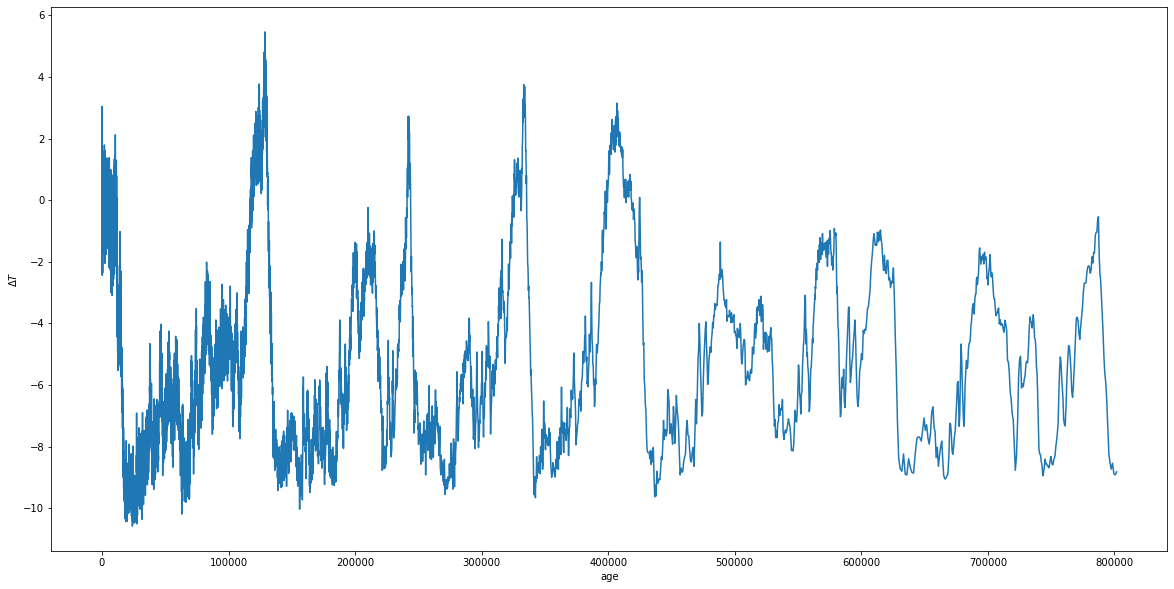

In [3]:
ice_data = np.loadtxt('ice_core_data.txt')
ice_data = np.transpose(ice_data)
age = ice_data[2]
T = ice_data[4]
plt.plot(age,T)
plt.xlabel('age')
plt.ylabel(r'$\Delta T$')
plt.show()

Great. Now, we can see that the temperature of Earth fluctuates a lot over its history, but that those fluctuations seem fairly periodic. It turns out, these fluctuations are due to combinations of small, but important periodic changes in the Earth's tilt (obliquity), rotational precession, orbital precession, eccentricity, and ecliptic inclination. Obliquity, rotational precession, and eccentricity are three primary effects that drive the fluctuations we see.

From the article, we can see that the periods of the Milankovich cycles are approximately 26,000 years, 41,000 years, and 100,000 years. While our model will actually end up fitting our periods for us, but having these numbers in mind will allow us to shorten our MCMC run by introducing **good priors**.

We can create a basic model for describing the above fluctuations as a sum of three sinusoids, which have different amplitudes and periods corresponding to roughly the Milankovich cycles. This won't work perfectly, but will be good enough for our purposes. Our model will be of the form

$$
\Delta T = a_1\sin(\frac{2\pi t}{p_1}) + a_2\sin(\frac{2\pi t}{p_2}) + a_3\sin(\frac{2\pi t}{p_3}) + T_0
$$

where  $a_1$,$a_2$,$a_3$,$p_1$,$p_2$,$p_3$,  and  $T_0$  are the parameters we will be fitting for.

# Setting up the MCMC code

We will be creating four functions for this MCMC run. The first is straightforward, and is known as the model. The model function should take as an argument a list representing our  $\theta$  vector, and return the model evaluated at that $\theta$ . For completion, your model function should also have your age array as an input, which here we can set to default to the age array defined above. Create your function below:

In [4]:
def model(theta,age=age):
    a1,a2,a3,p1,p2,p3,T0 = theta
    return a1*np.sin(2*np.pi*age/p1) + a2*np.sin(2*np.pi*age/p2) + a3*np.sin(2*np.pi*age/p3) + T0

We now need a function referred to as lnlike(). This function takes as an argument theta as well as the  $x$ ,  $y$ , and  $y_{\text{err}}$  of your actual theta. It's job is to return a number corresponding to how good a fit your model is to your data for a given set of parameters, weighted by the error in your data points (i.e. it is more important the fit be close to data points with small error bars than points with large error bars). We will use the following formulation to determine this number- translate it to a function in python below:

$$
L_{lnlike} = -\frac{1}{2} \Sigma (\frac{y - y_{\text{model}}}{y_{\text{err}}})^2
$$

In [5]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

The next function we need is one to check, before running the probability function (last one defined) on any set of parameters, that all variables are within their priors (in fact, this is where we set our priors).

The output of this function is totally arbitrary (it is just encoding True False), but emcee asks that if all priors are satisfied, 0.0 is returned, otherwise return -np.inf. Its input is a  $\theta$  vector.

Set up an lnprior function that specifies bounds on  $a1,a2,a3,p1,p2,p3$  and  $T_0$ . Reasonable bounds on the amplitudes can be drawn from the plot above (the amplitudes individually can't be greater than the overall amplitude of the final fluctuations, and  $T_0$  must be within the upper and lower bounds of the data we see). Priors on the periods are tricker, I suggest going for around ten thousand years around the known Milankovich cycle periods given above- we expect the values to be close to these. (We will talk a bit later about evaluating from "walker plots" whether our priors might not have been great).

In [6]:
def lnprior(theta):
    a1, a2, a3, p1, p2, p3, T0 = theta
    if 0.0 < a1 < 5.0 and 0.0 < a2 < 5.0 and 0.0 < a3 < 5.0 and 10000. < p1 < 200000 and 10000. < p2 < 200000 and 10000. < p3 < 200000 and -10.0 < T0 < 0:
        return 0.0
    return -np.inf

The last function we need to define is lnprob(). This function combines the steps above by running the lnprior function, and if the function returned -np.inf, passing that through as a return, and if not (if all priors are good), returning the lnlike for that model (by convention we say it's the lnprior output + lnlike output, since lnprior's output should be zero if the priors are good). lnprob needs to take as arguments *theta, x, y, and  yerr* , since these get passed through to lnlike.

In [14]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

We have one or two steps left before we can run. First, our Temperature measurements, unfortunately, have no errors provided. But we need errors for the MCMC to run, so let's set a yerr array arbitrarily to 5% of the average temperature in our temperature array.

We will want to feed our data (x,y,yerr) in as a tuple, so set data equal to a tuple of our age, temperature and temperature error arrays.

We also need to set a value for nwalkers, which determines how many walkers are initialized in our MCMC. Let's use 500.

We need a variable called initial, which is an initial set of guesses (this will be the first theta, where the MCMC starts).

Finally we need p0, which is the methodology of stepping from one place to a grid to the next ( I will provide this).

In [9]:
Terr = 0.05*np.mean(T)
data = (age, T,Terr)
nwalkers = 128
niter = 500
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [10]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

The sampler here contains all the outputs of the MCMC, including the walker chains and the posteriors. We will talk a little bit later about evaluating whether an MCMC has "converged," but for now let's quickly extract a random sampling of our posteriors and plot them over our data.

In [15]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


In [16]:
def plotter(sampler,age=age,T=T):
    plt.ion()
    plt.plot(age,T,label='Change in T')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(age, model(theta, age), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Years ago')
    plt.ylabel(r'$\Delta$ T (degrees)')
    plt.legend()
    plt.show()

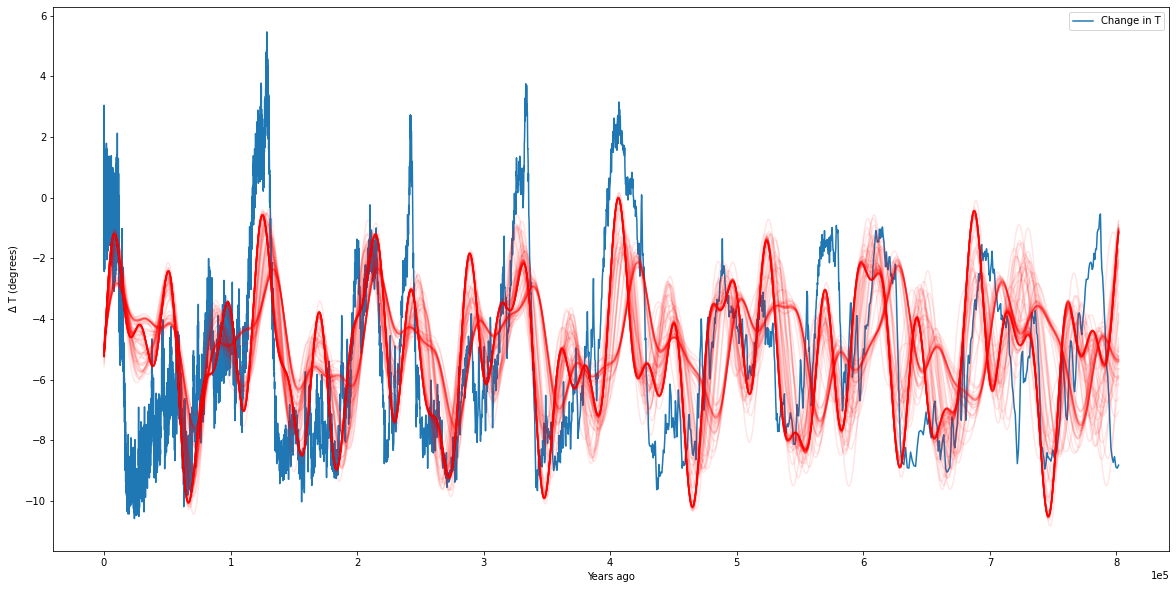

In [17]:
#sampler= main(p0)
plotter(sampler)

We can see from our plot that our simplistic model (of three sinusoids) is not perfect, but it does a pretty good job of matching our data. We can see that from the hundred samples we drew from the posteriors, they all seem to overlap over each other pretty well. We can see the exact values of our parameters as well:

In [18]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([ 1.32556185e+00,  2.08055311e+00,  1.89586769e+00,  2.35215738e+04,
        3.97338374e+04,  9.61363671e+04, -5.25638009e+00])

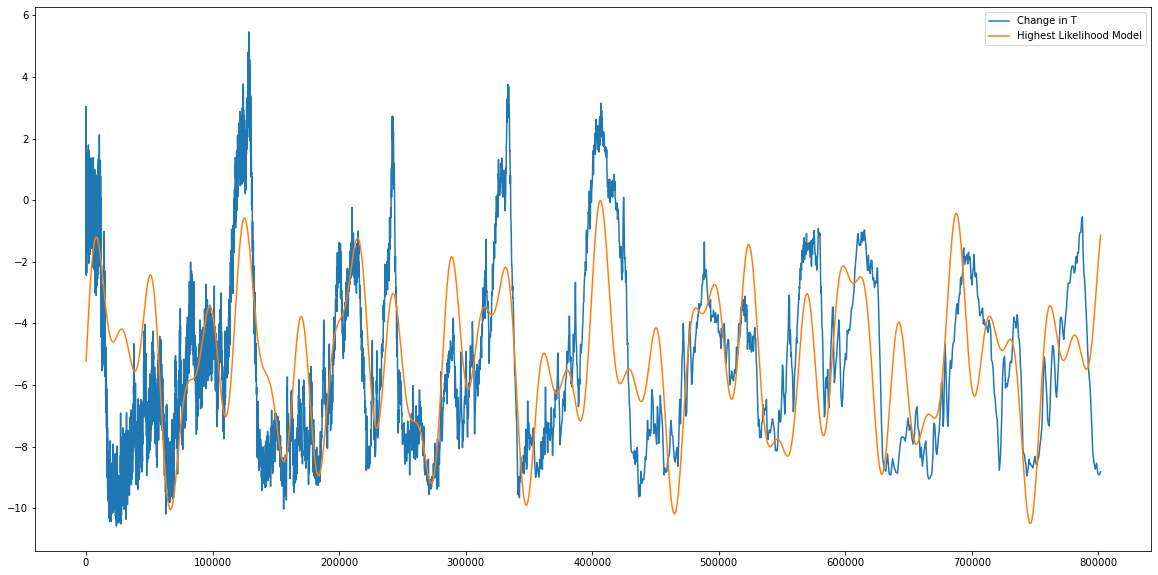

Theta max:  [ 1.32556185e+00  2.08055311e+00  1.89586769e+00  2.35215738e+04
  3.97338374e+04  9.61363671e+04 -5.25638009e+00]


In [23]:
#Highest Likelihood Parameters 
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.plot(age,T,label='Change in T')
plt.plot(age,best_fit_model,label='Highest Likelihood Model')
plt.legend()
plt.show()
print ('Theta max: ',theta_max)

## Posterior Spread

We can use the corner.py module to visualize 1D and 2D spreads between the parameters we are testing, and get some uncertainties on our parameter estimations.

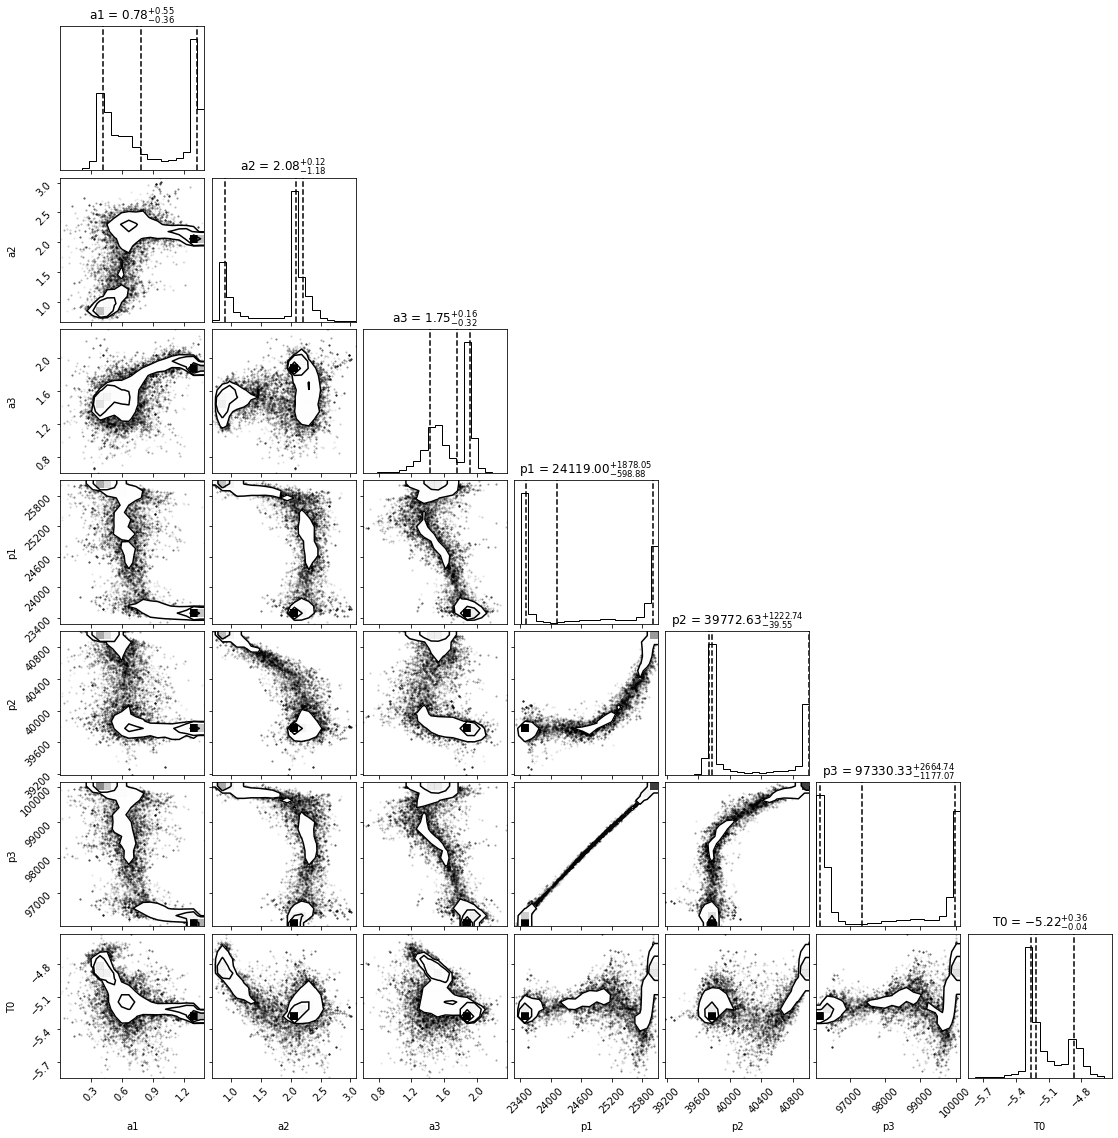

In [24]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In all honesty, these look pretty awful, with bimodalities and clumps all over the place. All of this is indicative of the fact that we chose a pretty crappy model in the first place. Take a look at a1: the two peaks at different amplitudes show that we haven't converged on a single answer, and if you look at the plot where I simply draw from the posteriors, at the very first peak you can see the two modes of amplitude. It's possible that more walkers and more iterations could help us solve this -- let's give it a try.

In [25]:
Terr = 0.05*np.mean(T)
data = (age, T,Terr)
nwalkers = 240
niter = 1024
initial = np.array([1.0, 1.0, 1.0, 26000., 41000.,100000.,-4.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]
new_sampler, newpos, newprob, newstate = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


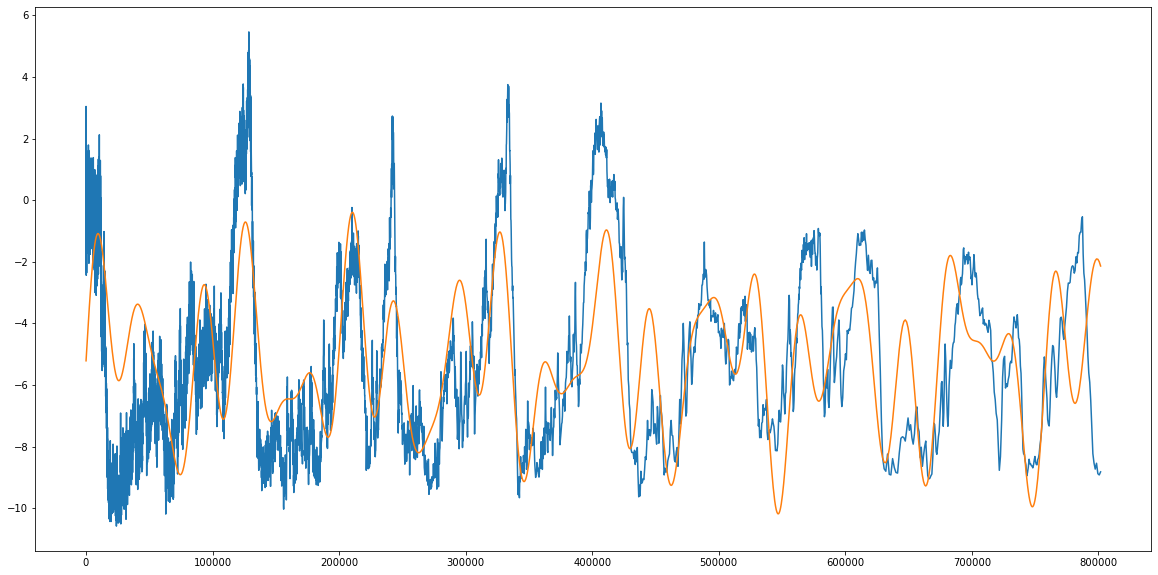

Theta max:  [ 1.20244270e+00  2.03247543e+00  1.82278439e+00  2.91382944e+04
  3.97655089e+04  9.60213279e+04 -5.24204519e+00]


In [26]:
new_samples =  new_sampler.flatchain

new_theta_max  = new_samples[np.argmax(new_sampler.flatlnprobability)]
new_best_fit_model = model(new_theta_max)
plt.plot(age,T,label='Change in T')
plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.show()
print ('Theta max: ', new_theta_max)

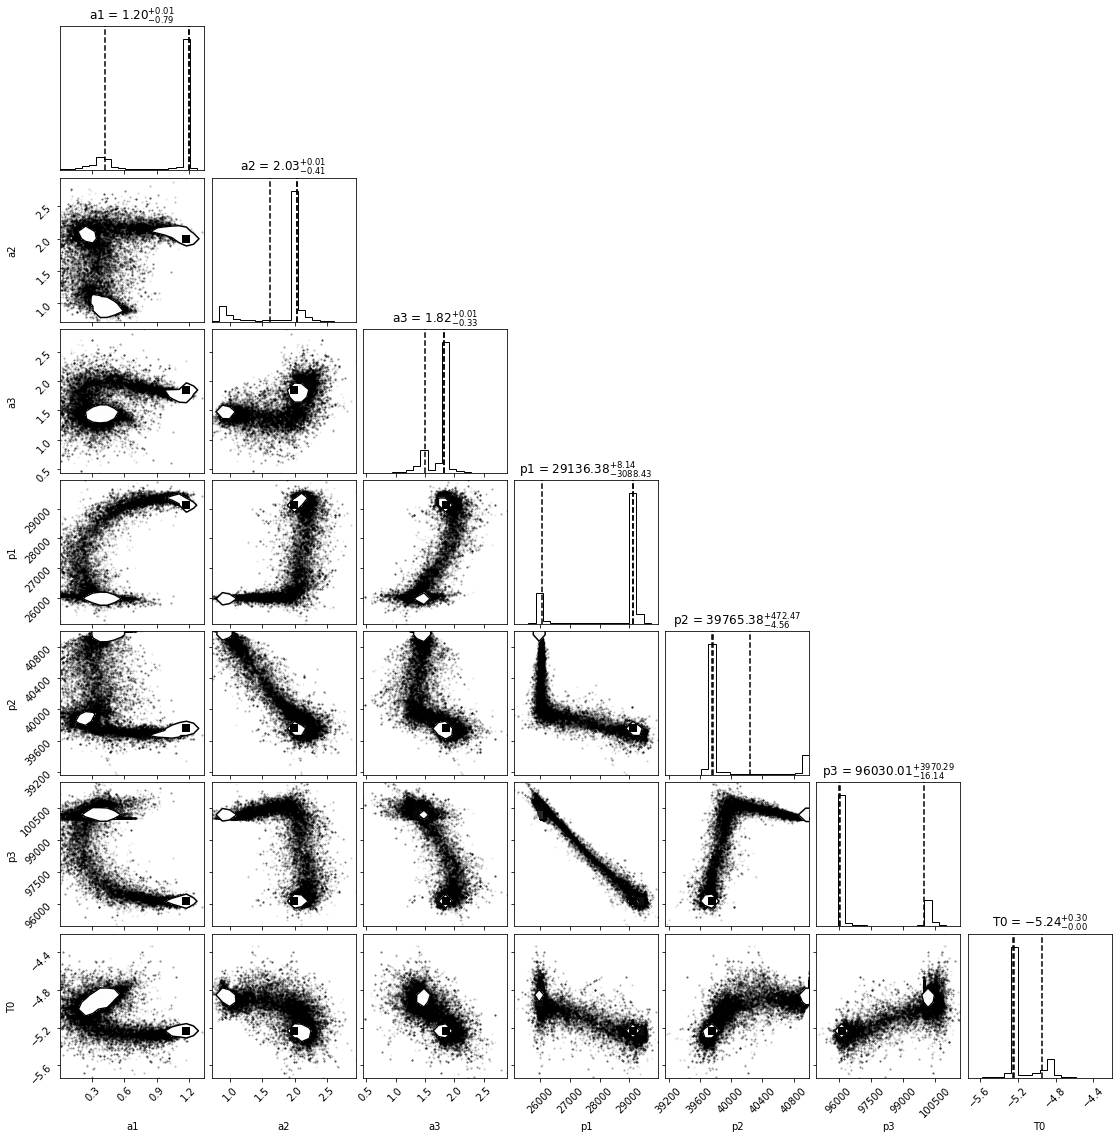

In [27]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(new_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

A lot of things still look crappy, but we can see that the secondary modes seems to be supressed -- most of the models now favor a single value. So what about plotting a one sigma spread in posteriors over the theta max we plotted? Easy! All we need to do is draw a random sample from the posteriors and find the spread at each "x-value" where we evaluated our model.

In [28]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,new_samples)

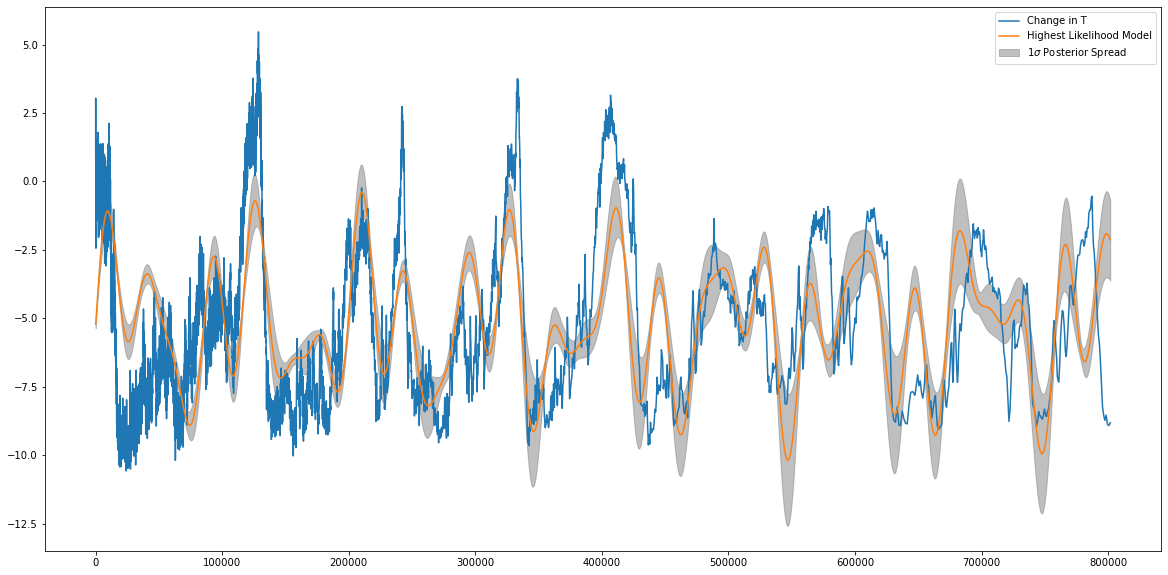

In [29]:
plt.plot(age,T,label='Change in T')
plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.fill_between(age,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
plt.legend()

Note that the "Most likely" model doesn't always have to (and sometimes doesn't) sit at the center of this spread- the spread is around the median model, but the one that absolutely maximizes the likelihood might sit at the edge or even outside this region.

This has been an interesting test example. It's worth noting that though our model was kind of crappy, using the data we were able to fit for the periods of the Milankovich cycles pretty accurately.